# Задание №3

Обучить СНС с помощью Transfer Learning на датасете Food-101.
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

> Возьмем предобученную сеть MobileNetV2 и дообучим в режимах Transfer learning и Fine-tuning
> Будем использовать веса MobileNetV2 на наборе Imagenet
> Целевым набором будет Food101

## MobileNet-v2
MobileNet-v2 является сверточной нейронной сетью, глубина которой составляет 53 слоя. Можно загрузить предварительно обученную версию сети, обученной больше чем на миллионе изображений от базы данных [ImageNet](https://image-net.org/). Предварительно обученная сеть может классифицировать изображения в 1 000 категорий объектов. В результате сеть изучила богатые представления функции для широкого спектра изображений. Сеть имеет входной размер изображений 224 224. [Статья](https://habr.com/ru/post/352804/)

## ImageNet
База данных ImageNet — проект по созданию и сопровождению массивной базы данных аннотированных изображений, предназначенная для отработки и тестирования методов распознавания образов и машинного зрения. По состоянию на 2016 год в базу данных было записано около десяти миллионов URL с изображениями, которые прошли ручную аннотацию для ImageNet, в аннотациях перечислялись объекты, попавшие на изображение, и прямоугольники с их координатами.[1] База данных с аннотацией и URL изображений от третьих лиц доступна непосредственно через ImageNet, но при этом сами изображения не принадлежат проекту[2]. С 2010 года ведётся проект ILSVRC (англ. ImageNet Large Scale Visual Recognition Challenge — Кампания по широкомасштабному распознаванию образов в ImageNet), в рамках которого различные программные продукты ежегодно соревнуются в классификации и распознавании объектов и сцен в базе данных [ImageNet](https://ru.wikipedia.org/wiki/ImageNet).

## Food-101
Этот набор данных состоит из 101 категории продуктов питания и 101 000 изображений. Для каждого класса предоставляется 250 проверенных вручную тестовых изображений, а также 750 обучающих изображений. Учебные изображения намеренно не очищались и поэтому все еще содержат некоторое количество шума. В основном это проявляется в виде интенсивных цветов и иногда неправильных этикеток. Все изображения были масштабированы таким образом, чтобы максимальная длина стороны составляла 512 пикселей. [food101](https://www.tensorflow.org/datasets/catalog/food101)



In [1]:
# для локальноого прогона
#!pip install tensorflow-datasets

## Импорт данных

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food101

In [22]:
%%time
# tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:10%]', 'validation[:10%]'],
)

label_names = ds_info.features['label'].names

CPU times: user 66.4 ms, sys: 819 µs, total: 67.2 ms
Wall time: 72.9 ms


> Будем использовать 10% оригинальной базы для ускорения обучения

In [23]:
print(f'Train exemples: {len(train_ds)}')
print(f'Test examples: {len(test_ds)}')
print(f'Labels: {len(label_names)}')

Train exemples: 7575
Test examples: 2525
Labels: 101


## Визуализация набора Food101

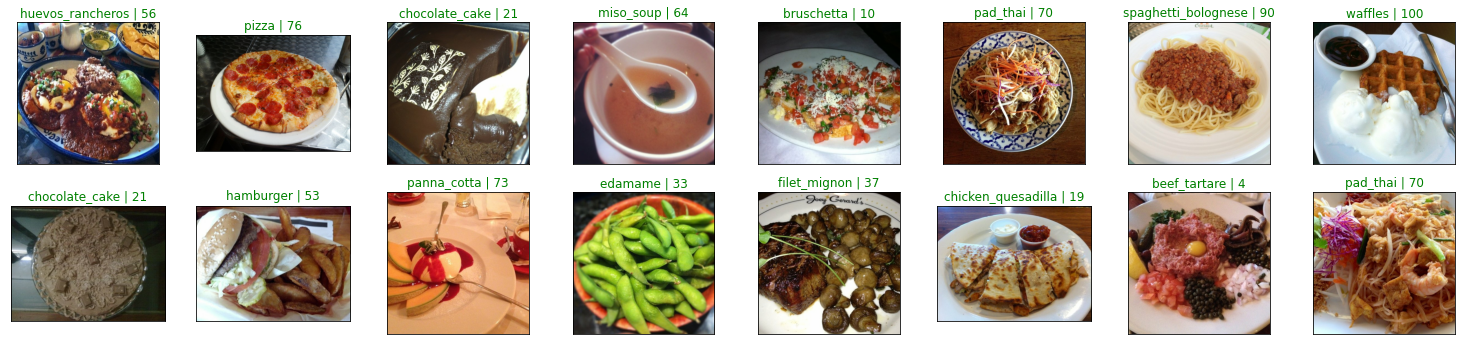

In [24]:
some_samples = [x[0] for x in iter(train_ds.take(16))]
some_labels = [x[1].numpy() for x in iter(train_ds.take(16))]

fig = plt.figure(figsize=(26, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j + 1)
    ax.imshow(some_samples[j])
    ax.set_title(label_names[some_labels[j]] + ' | ' + str(some_labels[j]), c='green')
    plt.xticks([]), plt.yticks([])
plt.show()

> Необходимо привести высоту и ширину

In [25]:
for i in some_samples[:10]:
  print(i.shape)

(512, 512, 3)
(384, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(384, 512, 3)
(384, 512, 3)


In [26]:
img_w = set()
img_h = set()
for item in train_ds:
  if item[0].shape[0] != 512:
    img_w.add(item[0].shape[0])
  elif item[0].shape[1] != 512:
    img_h.add(item[0].shape[1])
print(f'Min width: {min(img_w)}\nMin height: {min(img_h)}')

Min width: 181
Min height: 223


## Создание пайплайна данных

In [14]:
INP_SIZE = 224
NUM_EPOCHS = 1
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000

In [27]:


def resize_images(img, label):
    img = tf.cast(img, tf.float32) / 127. - 1.  # значения от -1 до 1 для модели MobileNetV2
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.map(resize_images, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=BUFFER_SIZE)
test_ds = test_ds.map(resize_images, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(128, drop_remainder=True)

## Подготовка модели

In [ ]:
class BuildModel:
    INP_SIZE = 224
    LEARNING_RATE = 0.0001

    def __init__(self, is_fine_tuning=False) -> None:
        self.is_fine_tuning = is_fine_tuning
        basemodel = self.build_base(self.is_fine_tuning)
        basemodel.trainable = is_fine_tuning
        self.model = self.build_seq(basemodel)
        optimizer = self.get_optimizer()
        self.compile(optimizer=optimizer)

        print('The model', self.get_name(), 'initialised...')

    def build_seq(self, basemodel):
        return tf.keras.Sequential(
            [basemodel,
             tf.keras.layers.GlobalAveragePooling2D(),
             tf.keras.layers.Dense(101, activation='softmax'),
             ])

    def get_optimizer(self):
        return tf.keras.optimizers.Adam(learning_rate=self.LEARNING_RATE)

    def compile(self, optimizer):
        model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    def get_tensorboard_callback(self):
        return tf.keras.callbacks.TensorBoard(
        log_dir='logs/' + self.get_name(),
        write_graph=False, update_freq=100, profile_batch=0)

    def get_name(self):
        name = self.__class__.__name__
        if not self.is_fine_tuning:
            name += '_frozen'
        return name

    def build_base(self, is_fine_tuning):
        return None

    def predict(self, img, label_names):
        pred = self.model(img[None, ...], training=False)
        pred_label=label_names[np.argmax(pred)]
        print(f'Prediction: {pred_label}')

class MobilNet(BuildModel):
    def build_base(self, is_fine_tuning):
        model = tf.keras.applications.MobileNetV2(
            input_shape=(self.INP_SIZE, self.INP_SIZE, 3),
            include_top=False,
            weights='imagenet')
        return model


class EfficientNet(BuildModel):
    def build_base(self, is_fine_tuning):
        model = tf.keras.applications.EfficientNetV2S(
            input_shape=(self.INP_SIZE, self.INP_SIZE, 3),
            include_top=False,
            weights='imagenet',
            include_preprocessing=False, )
        return model


## Подготовка к обучению

In [ ]:
model = MobilNet(is_fine_tuning=False).model


## Структура модели

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


## Обучение модели

In [36]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

236/236 [==============================] - 33s 125ms/step - loss: 4.5261 - accuracy: 0.0388 - val_loss: 4.0928 - val_accuracy: 0.0929
CPU times: user 49.8 s, sys: 1.03 s, total: 50.9 s
Wall time: 32.7 s


## Оценка качества модели


In [32]:
history_test = model.evaluate(test_ds)
history_test

19/19 [==============================] - 6s 264ms/step - loss: 4.1134 - accuracy: 0.0876


[4.11336088180542, 0.08758223801851273]

## Панель TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%` not found.


## Разпознавание картинки

In [ ]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget http://2.bp.blogspot.com/-J0Vcs9F784o/UftuvDLCkjI/AAAAAAAAAUc/k98iv88segk/s1600/%D0%BD%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F+%D0%B5%D0%B4%D0%B0+%D0%98%D1%82%D0%B0%D0%BB%D0%B8%D0%B8.jpg

img = imageio.imread('/content/национальная+еда+Италии.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [1]:
import imageio.v3 as iio
import io
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

In [3]:
url = 'http://2.bp.blogspot.com/-J0Vcs9F784o/UftuvDLCkjI/AAAAAAAAAUc/k98iv88segk/s1600/%D0%BD%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F+%D0%B5%D0%B4%D0%B0+%D0%98%D1%82%D0%B0%D0%BB%D0%B8%D0%B8.jpg'

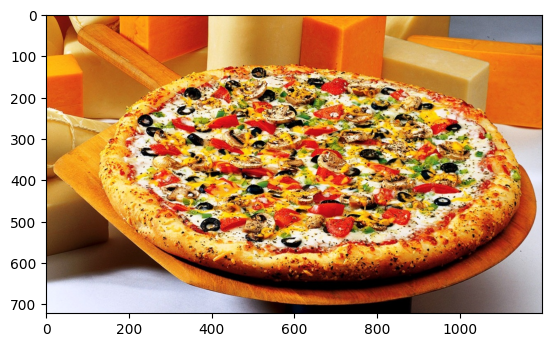

In [7]:
img = iio.imread(url, index=None)
plt.imshow(img)


In [ ]:
pred = model(img[None, ...], training=False)

pred_label = label_names[np.argmax(pred)]
print(f'Prediction: {pred_label}')

In [8]:
class prob_image:
    def __init__(self, url):
        self.img = iio.imread(url, index=None)

    def show(self):
        plt.imshow(self.img)

    def prepare_image(self):
        img = self.img.astype(np.float32)/127. - 1.
        img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
        return img.astype(np.float32)

In [9]:
img1 = prob_image(url)

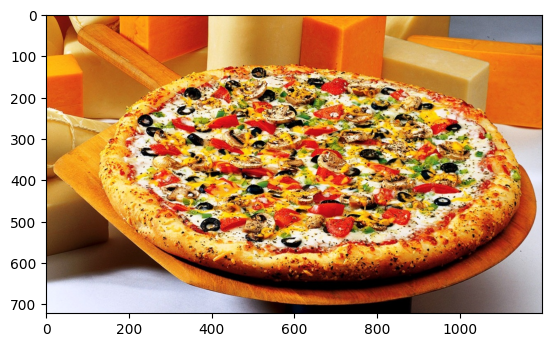

In [12]:
img1.show()

In [15]:
img1.prepare_image()

array([[[ 0.72596186,  0.16845217, -0.6996268 ],
        [ 0.7352521 ,  0.17836651, -0.6901772 ],
        [ 0.6954304 ,  0.10416808, -0.7231941 ],
        ...,
        [-0.16369478, -0.11973886, -0.00126339],
        [-0.17134997, -0.12826295,  0.00870898],
        [-0.18661538, -0.1319862 ,  0.01521672]],

       [[ 0.72246563,  0.16116102, -0.6906374 ],
        [ 0.7203082 ,  0.16255747, -0.7027881 ],
        [ 0.7238096 ,  0.14545877, -0.7267176 ],
        ...,
        [-0.16222441, -0.1108921 ,  0.00331262],
        [-0.1471688 , -0.10133274,  0.02963952],
        [-0.17491604, -0.12530853,  0.01878921]],

       [[ 0.7022259 ,  0.13805422, -0.69709414],
        [ 0.7009005 ,  0.14274152, -0.71871805],
        [ 0.7248282 ,  0.15263505, -0.73224646],
        ...,
        [-0.13513383, -0.08107202,  0.03874481],
        [-0.13756889, -0.09274615,  0.04130296],
        [-0.16510287, -0.12477165,  0.02370396]],

       ...,

       [[ 0.89921606,  0.9305677 ,  1.0078489 ],
        [ 0